# Face and Mask

In [1]:
import cv2
import matplotlib.pyplot as plt
import helpers
import numpy as np
import tensorflow as tf
import glob
import random
import matplotlib.patches as patches
from retinaface import RetinaFace
from PIL import Image
from od_metrics.BoundingBox import BoundingBox
from od_metrics.BoundingBoxes import BoundingBoxes
from od_metrics.utils import BBFormat, BBType
from od_metrics.Evaluator import Evaluator
import time

## Load Kaggle Dataset
Kaggle dataset has 853 images

In [2]:
# load images and associated faces
# this takes a second since we load with cv2
imgs_with_labels = helpers.load_kaggle_863('../kaggle_dataset_863')
imgs_with_labels = helpers.convert_kaggle_863_for_metrics(imgs_with_labels)

## Facial Recognition
We use retinaface to detect facial features

In [3]:
# Initialize facial detection
detector = RetinaFace(quality = "normal")

model[normal quality] init ..
model success !


In [4]:
dl_detection_results = {}
dl_detection_results['retinaface_mobilenet_alt'] = imgs_with_labels['bboxes'].clone()
detections = dl_detection_results['retinaface_mobilenet_alt']

In [5]:
a = time.time()
#Detect faces and crop them, add the cropped Faces into cropImages
cropCoordinates = []
cropImages = []
cnt = 0
for img_name, img_data in imgs_with_labels['raw_data'].items():
    img = img_data['img']
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # using default threshold
    faces = detector.predict(rgb_img.astype(np.float32), threshold=0.7)
    cropCoordinates.append(faces)
    #Crop faces and add them to cropImages
    img = Image.fromarray(rgb_img)
    cropFaces = []
    for face in faces:
        cropFaces.append(img.crop((face['x1'], face['y1'], face['x2'], face['y2'])))
        
    cropImages.append(cropFaces)
    
    cnt += 1
    if cnt%25 == 0: print(cnt)
print("Time taken for retinaface to go through 853 images: ", time.time()-a)

25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
Time taken for retinaface to go through 853 images:  213.77782773971558


## Mask Detection
we will now pass cropImages through the mask classifier

In [6]:
dim = 64

# I am passing in PIL images, this converts it to PIL
def resize_img(pic):
    image_array = tf.keras.preprocessing.image.img_to_array(pic)
    img = tf.convert_to_tensor(image_array, dtype = 'uint8')
    img = tf.image.resize(img, [dim, dim])
    img = img/127.5-1
    return img

In [7]:
# The neural network

def conv_model(num_blocks, rate, dim):
    
    input = tf.keras.layers.Input(shape=(dim,dim,3))
    
    x = tf.keras.layers.Conv2D(16, (16,16), strides=1)(input)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    for i in range(num_blocks-1):
        x = tf.keras.layers.Conv2D(8, (8,8), strides=1)(x)
        x = tf.keras.layers.Dropout(rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
    x = tf.keras.layers.Conv2D(filters=2, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)
    
    model = tf.keras.Model(inputs=input, outputs=predictions)
    print(model.summary())
    
    return model

In [8]:
num_blocks = 3
dropout = .1
model = conv_model(num_blocks,.1, dim)
model.load_weights('mask_classification_model_3_50.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 49, 49, 16)        12304     
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 49, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 8)         8200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 8)         0     

In [9]:
# Prediction function, passes in PIL image
def pred(pic):
    im = resize_img(pic) # Convert and resize PIL image to 64x64 tensor
    vals = model.predict(np.expand_dims(im,axis=0))
    if vals[0][0] >= vals[0][1]:
        prediction = 0
    else:
        prediction = 1     
    r = maskResult(vals, prediction)
    
    return r

In [10]:
class maskResult:
    def __init__(self, vals, prediction):
        self.vals = vals
        self.prediction = prediction

In [11]:
b = time.time()
maskPredictions = []
cnt = 0

for img in cropImages:
    imagePredictions = []
    for face in img:
        imagePredictions.append(pred(face))
    maskPredictions.append(imagePredictions)
    cnt += 1
    if cnt%25 == 0: print(cnt)
        
print("Time classify faces through 853 images:", time.time()-b)

25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
Time classify faces through 853 images: 116.31808304786682


## Display Sample Prediction

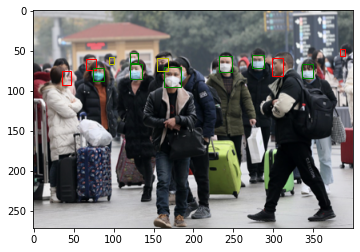

In [12]:
img_index = 523

img_name, img_data = list(imgs_with_labels['raw_data'].items())[img_index]
img = np.copy(img_data['img'])
img = helpers.to_rgb(img)

fig,ax = plt.subplots(1)
ax.imshow(img)

#Draw a box around each face
j = 0
for coord in cropCoordinates[img_index]:
    maskval = maskPredictions[img_index][j].vals[0][1]
    if maskval< 0.3:
        color = 'g'
    elif maskval < 0.7:
        color = 'y'
    else:
        color = 'r'
    rect = patches.Rectangle((coord['x1'],coord['y1']),(coord['x2']-coord['x1']),(coord['y2']-coord['y1']),linewidth=1,edgecolor=color,facecolor='none')
    ax.add_patch(rect)
    j = j+1
    
plt.show()
    